# Results Optiwise inverse dynamics

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation

In [4]:
ship_name = "optiwise"

In [5]:
#%reload_kedro
loaders = {
    "polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
    "measured rudder" : catalog.load(f"{ship_name}.models_measured_rudder_force")['semiempirical_covered_inertia'],
}
ship_data = catalog.load(f"{ship_name}.ship_data")

[11/12/24 14:56:38] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=81610;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=399080;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=998618;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=543617;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=905527;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=730403;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=776676;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=327124;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_measured_rudder_force'          ]8;id=397962;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=263165;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.ship_data' (YAMLDataSet)...            ]8;id=347849;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=129463;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [6]:
models = {name:loader() for name,loader in loaders.items()}
model = models["polynomial rudder"]

In [46]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

meta_datas_all = meta_datas_all.groupby('test_type').get_group('zigzag')
mask = meta_datas_all['ship_speed'] > 0.9
meta_datas_all = meta_datas_all.loc[mask].copy()

[11/12/24 15:30:23] INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=2306;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=606012;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [32]:
meta_datas = meta_datas_all.loc[[23590, 23591, 23594, 23596]].copy()

## Compare forces

In [11]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

[11/12/24 14:57:07] INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=263964;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=715008;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [12]:
round = {
    'u':4,
    'v':4,
    'r':4,
    'delta':4,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    points = pd.merge(left=df_EKF_smooth, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=495587;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=129711;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=47245;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=752693;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=701482;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=584126;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=878798;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=222146;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=978173;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=180895;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=307258;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=171780;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=348794;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=254262;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=732725;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=511183;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/12/24 14:57:08] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=599906;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=619000;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=416883;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=916782;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

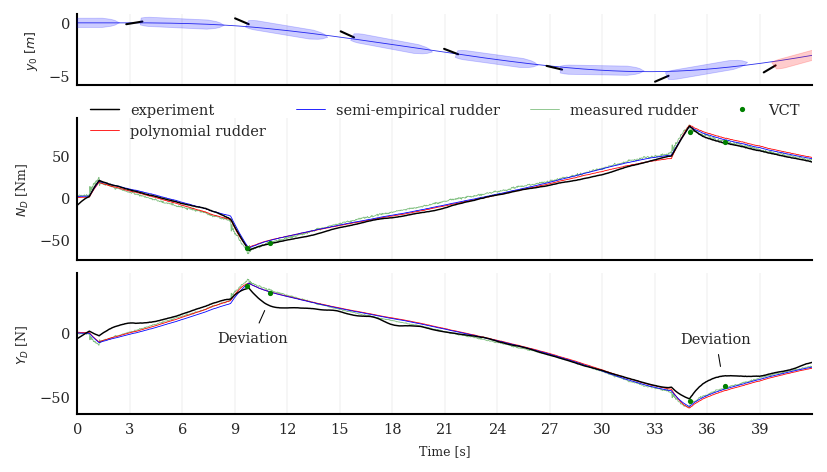

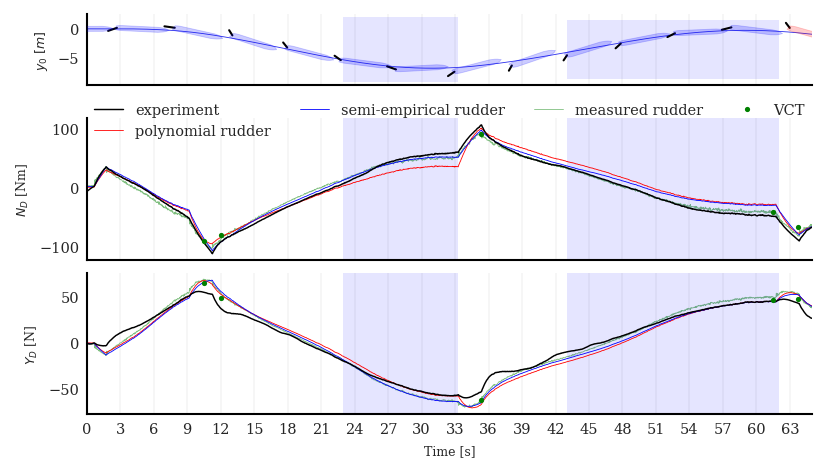

In [13]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units, symbols=symbols);
    
    

    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    if id==23594:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)

        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)

    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

## Closed loop simulation

[11/12/24 15:51:35] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=108233;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=722623;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=297030;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=229669;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=648466;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=730060;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=844072;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=656696;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=816556;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=999317;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:36] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=18301;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=328355;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=654847;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=699604;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=946960;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=743960;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:37] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=732058;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=933184;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=721730;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=186338;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=153292;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=671582;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=96042;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=741260;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=654394;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=217577;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:38] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=11461;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=799432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=61597;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=671352;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=159009;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=868769;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:39] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=976962;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=35658;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=2428;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=257112;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=58130;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=367831;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=379144;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=472108;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=188520;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=66904;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/12/24 15:51:40] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=852808;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=401609;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=65338;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=949716;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=965845;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=5890;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:41] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=422158;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=491579;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=500791;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=189501;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=677627;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=423271;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:42] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=86640;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=15957;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=884942;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=629593;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=195436;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=839032;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=461701;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=576486;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=94934;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=279497;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:43] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=832265;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=808452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=943800;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=154470;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=817998;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=317044;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/12/24 15:51:44] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=165978;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=351454;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=414838;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=109088;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=967632;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=204556;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

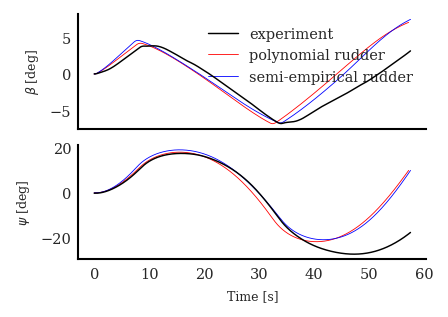

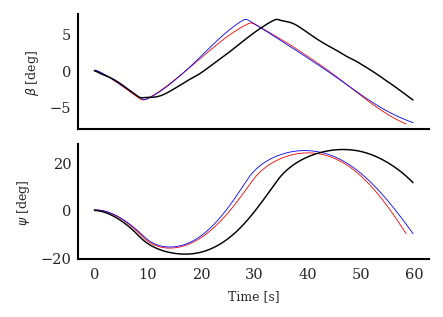

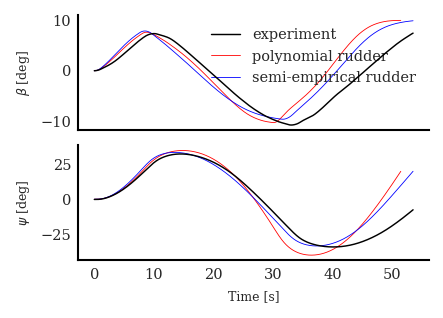

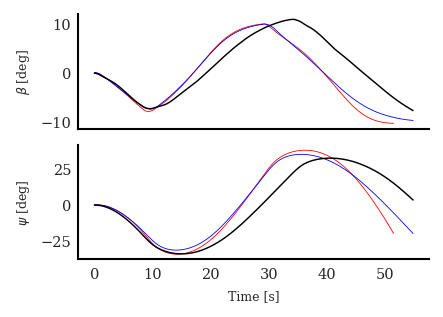

In [81]:
simulations = {}

for angle, group in meta_datas.groupby(by='angle1'):

    #fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
        df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
        df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():

            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            if model_name == "measured rudder":
                #df_simulation = model.simulate(data)
                continue
            else:
                df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
            
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        #track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        #fig = ax.get_figure()
        
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        #fig.suptitle(name)
        #file_name = name.replace("/","_")
        #paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta'], units=units, styles=styles, ncols=1, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)

        fig.set_size_inches(paper.figure_width/2,paper.figure_height*2/3)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [51]:
mask = pd.notnull(meta_datas_all['angle'])
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas_all[['angle','comment']]

,angle,comment
23590,-10.0,ZZ10/10 SB
23591,10.0,ZZ10/10 SB
23592,-10.0,ZZ10/10 SB
23593,10.0,ZZ10/10 PS
23594,-20.0,ZZ20/20 SB
23595,-20.0,ZZ20/20 SB
23596,20.0,ZZ20/20 PS
23597,20.0,ZZ20/20 PS
23679,-10.0,ZZ10/10 SB
23680,10.0,ZZ10/10 PS


In [52]:
IMO_evaluation.measure_overshoots(df_simulation)


14.05    11.540788
35.59    15.146895
Name: psi, dtype: float64

In [53]:
IMO_evaluation.measure_overshoots(df_EKF_smooth)


time
22.150020     15.600310
61.010015     17.045651
101.390001    10.544116
Name: psi, dtype: float64

In [91]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [190]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[11/12/24 17:15:17] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=506646;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=296083;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=20177;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=441320;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=603357;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750073;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=42290;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35013;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=914875;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=740730;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=148642;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=950443;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=733505;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=198988;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=12073;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=618689;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=645146;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=82061;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=815993;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=96734;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=736176;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=53840;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=645171;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=491072;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [191]:
overshoot_results.sort_values(by='angle')

,overshoot_1,t_1,overshoot_2,t_2,angle,overshoot_3,t_3
23594,12.275516,15.180002,13.988310,40.799998,-20.0,10.929683,68.279999
23595,12.687193,15.399989,14.028674,41.460002,-20.0,10.805342,68.809988
23682,12.451062,15.340005,13.836021,41.039996,-20.0,11.003151,68.630016
23590,7.432821,16.550008,17.138650,47.909988,-10.0,NaN,NaN
23592,7.625012,17.079992,17.168450,47.769985,-10.0,NaN,NaN
23679,7.886254,17.329988,17.687529,49.059983,-10.0,NaN,NaN
23591,8.464648,17.709999,15.291949,47.250018,10.0,NaN,NaN
23593,8.537342,17.669989,15.042208,47.099989,10.0,NaN,NaN
23680,8.724413,17.660002,14.986429,47.369995,10.0,NaN,NaN
23596,14.046294,15.659982,12.413888,41.269992,20.0,12.360698,68.659995


In [192]:
meta_data['angle']

-20.0

In [193]:
overshoot_results['id'] = overshoot_results.index

<Axes: xlabel='id'>

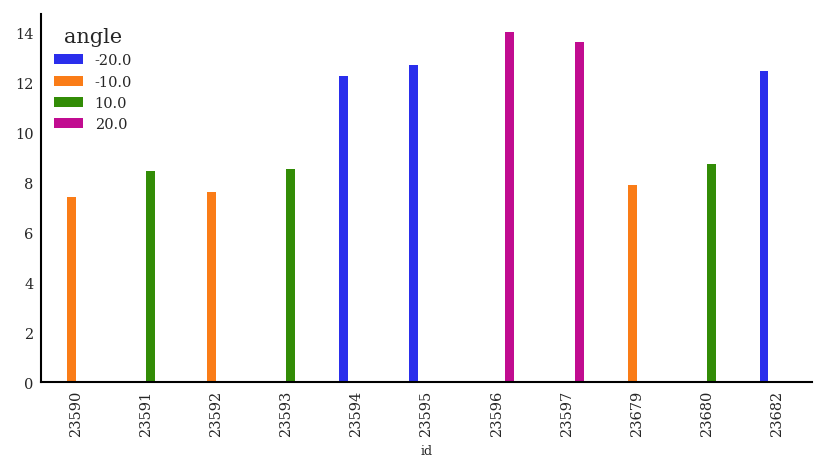

In [194]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').transpose().plot.bar()

<Axes: xlabel='angle'>

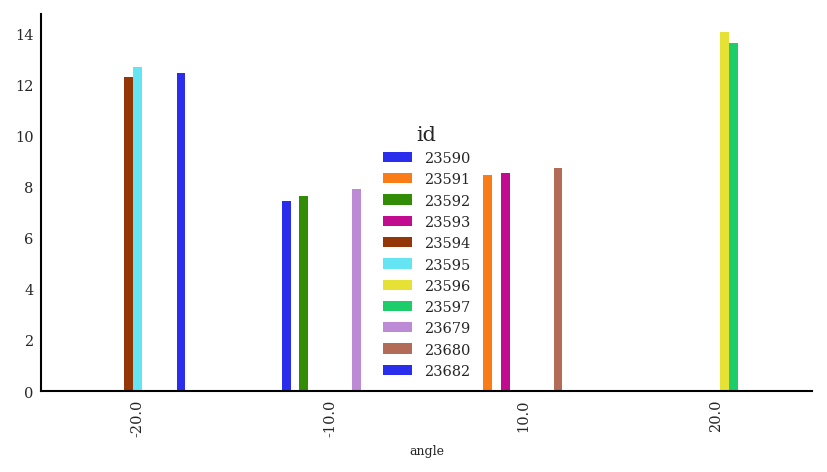

In [195]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').plot.bar()

In [196]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [197]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,id
angle,,,,,,,
-20.0,0.206580,0.113720,0.101601,0.334068,0.099988,0.269503,50.520623
-10.0,0.227591,0.398278,0.308653,0.707835,NaN,NaN,50.816664
10.0,0.134014,0.026458,0.162699,0.135281,NaN,NaN,50.816664
20.0,0.302530,0.070699,0.168781,0.127267,0.155845,0.028285,0.707107


In [198]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [215]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [216]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3,angle_abs
0.0,8.068671,15.560000,11.684300,40.400000,23590.000000,polynomial rudder,-10,NaN,NaN,10.0
1.0,9.099848,15.530000,10.811055,41.690000,23590.000000,semiempirical rudder,-10,NaN,NaN,10.0
2.0,6.019392,14.110000,13.955066,39.980000,23591.000000,polynomial rudder,10,NaN,NaN,10.0
3.0,5.558163,14.150000,14.922142,39.380000,23591.000000,semiempirical rudder,10,NaN,NaN,10.0
4.0,14.836792,14.830000,19.933643,36.440000,23594.000000,polynomial rudder,-20,NaN,NaN,20.0
5.0,13.501641,13.490000,13.368232,37.320000,23594.000000,semiempirical rudder,-20,NaN,NaN,20.0
6.0,14.346216,14.220000,18.026230,36.220000,23596.000000,polynomial rudder,20,NaN,NaN,20.0
7.0,11.540788,14.050000,15.146895,35.590000,23596.000000,semiempirical rudder,20,NaN,NaN,20.0
-20.0,12.471257,15.306665,13.951002,41.099999,23623.666667,experiment,-20,10.912725,68.573334,20.0
-10.0,7.648029,16.986663,17.331543,48.246652,23620.333333,experiment,-10,NaN,NaN,10.0


In [217]:
styles


{
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'experiment'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': 'b-', 'label': 'semi-empirical rudder'},
    'measured rudder': {'style': 'g-', 'zorder': -100, 'alpha': 0.5, 'label': 'measured rudder'}
}

In [236]:
def name(row):
    angle = row.name
    direction = "port" if angle > 0 else "stbd"
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f} {direction}"
    return name

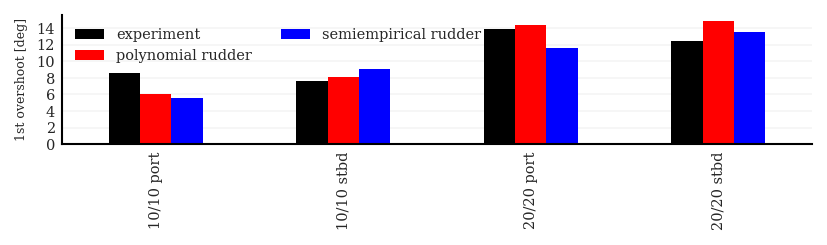

In [262]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=['k','r','b'], ax=ax)
ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

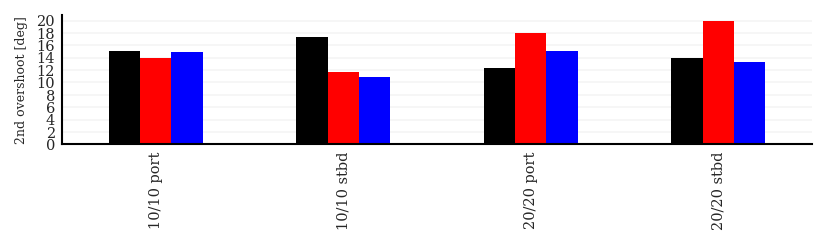

In [263]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=['k','r','b'], ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [232]:
overshoot_simulation_results_pivot

model_name,experiment,polynomial rudder,semiempirical rudder,name
angle,,,,
-20,12.471257,14.836792,13.501641,20/20 stbd
-10,7.648029,8.068671,9.099848,10/10 stbd
10,8.575468,6.019392,5.558163,10/10 port
20,13.832373,14.346216,11.540788,20/20 port


<Axes: >

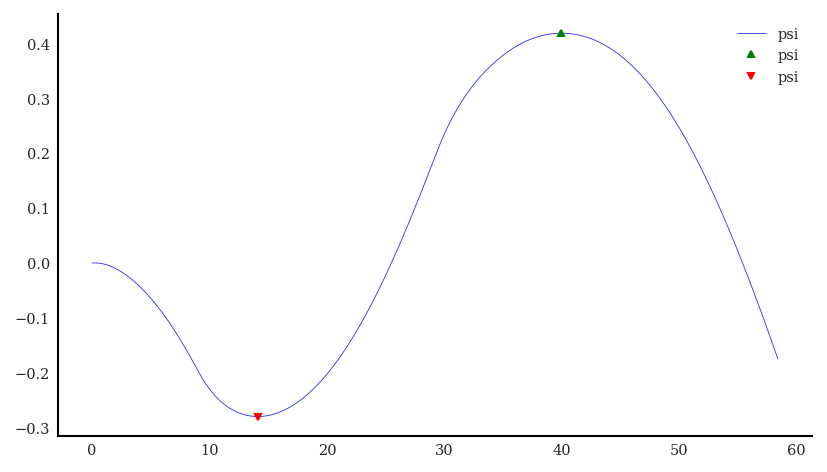

In [201]:
df_simulation = simulations[23591]['polynomial rudder']

maximums = IMO_evaluation.maximums(df_simulation)
minimums = IMO_evaluation.minimums(df_simulation)

fig,ax=plt.subplots()
df_simulation.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

[11/12/24 17:15:40] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=745742;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=203742;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

<Axes: xlabel='time'>

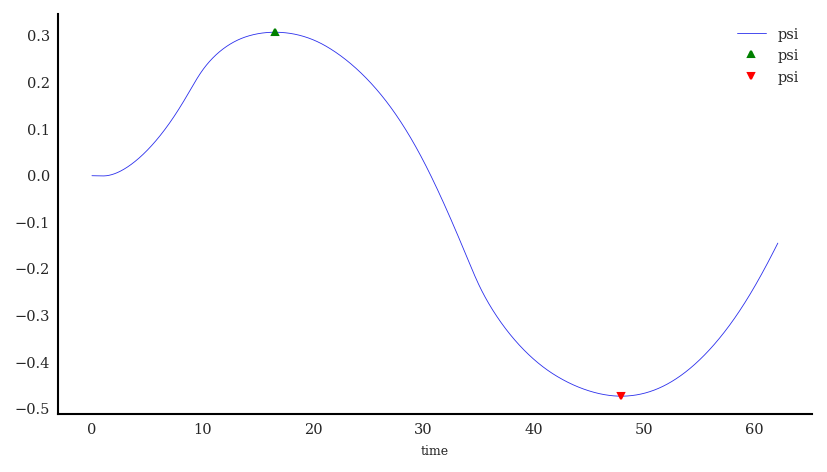

In [202]:
id = 23590
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()

maximums = IMO_evaluation.maximums(df_EKF_smooth, angle=10)
minimums = IMO_evaluation.minimums(df_EKF_smooth, angle=10)

fig,ax=plt.subplots()
df_EKF_smooth.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

In [220]:
meta_datas_all.loc[23590]['angle']

-10.0

In [203]:
IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=10)


time
16.550008     7.432821
47.909988    17.138650
Name: psi, dtype: float64

<Axes: xlabel='time'>

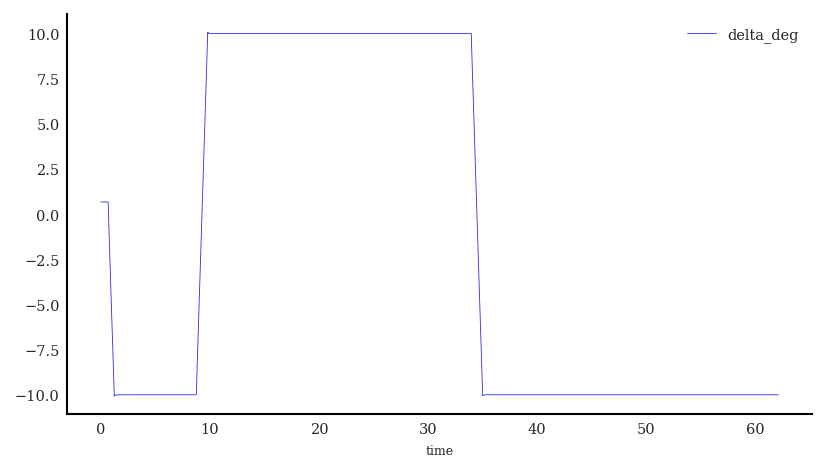

In [204]:
df_EKF_smooth['delta_deg'] = np.rad2deg(df_EKF_smooth['delta'])
df_EKF_smooth.plot(y='delta_deg')